# Евсеев Г.А. РТ5-61Б. Лабораторная работа №6.

# "Анализ и прогнозирование временного ряда".

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from gplearn.genetic import SymbolicRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Использован датасет, содержащий данные об изменении численности населения: https://www.kaggle.com/datasets/census/population-time-series-data?datasetId=51748&sortBy=voteCount

In [2]:
data = pd.read_csv('dataset.txt')
data.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [5]:
data.dtypes

date      object
value    float64
dtype: object

In [9]:
# Преобразуем столбец "date" к datetime и установка его в качестве индекса
data['date'] = pd.to_datetime(data['date'])
data.set_index('date',inplace=True)
data.head()

KeyError: 'date'

In [11]:
data.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [10]:
data.describe()

,value
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


## Визуализация временного ряда

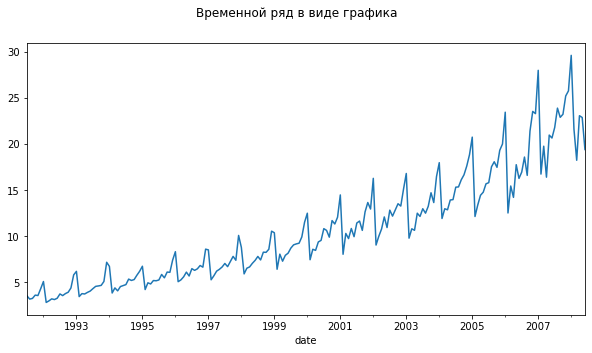

In [12]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

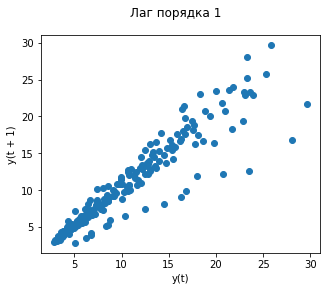

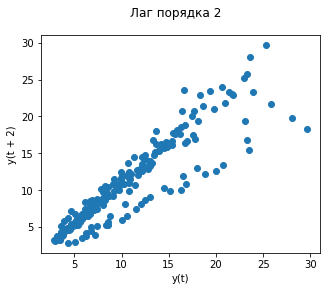

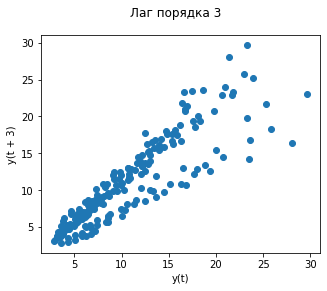

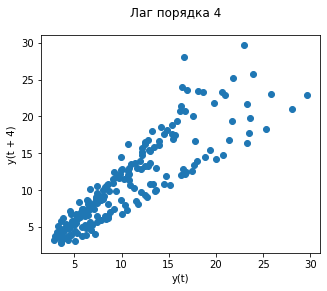

In [13]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(data, lag=i, ax=ax)
    pyplot.show()

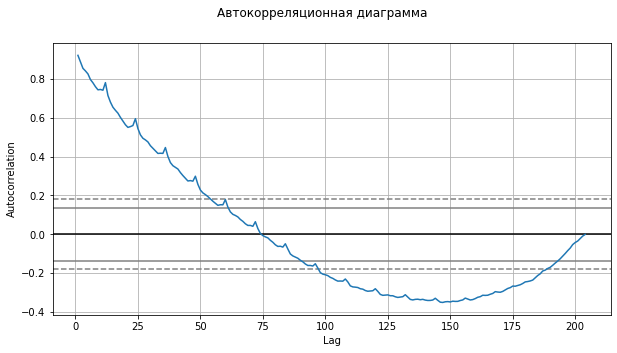

In [14]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(data, ax=ax)
pyplot.show()

### Автокорреляционная функция

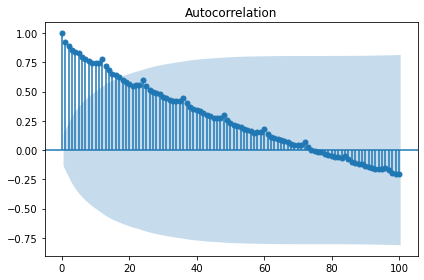

In [15]:
plot_acf(data, lags=100)
plt.tight_layout()

### Частичная автокорреляционная функция

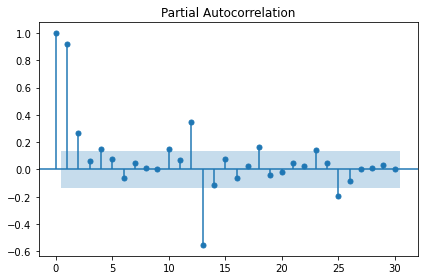

In [16]:
plot_pacf(data, lags=30, method='ywm')
plt.tight_layout()

### Декомпозиция временного ряда

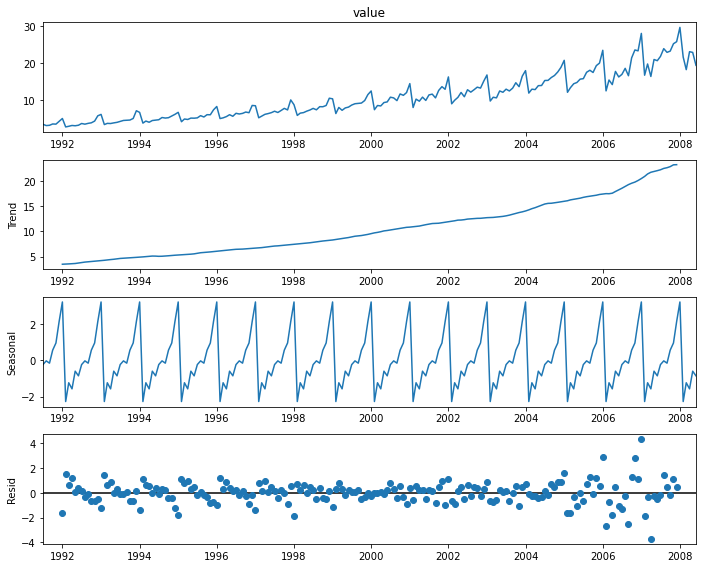

In [17]:
decomposed = seasonal_decompose(data['value'], model = 'add')
fig = decomposed.plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

## Разделение временного ряда на обучающую и тестовую выборку

In [18]:
data_2 = data.copy()

In [19]:
# Целочисленная метка шкалы времени 
xnum = list(range(data_2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data_2['value'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]

## Прогнозирование временного ряда авторегрессионным методом (ARIMA)

In [20]:
# Параметры модели (p,d,q) 
arima_order = (2,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [21]:
# Ошибка прогноза
np.mean(Y), error_arima

(10.694429582156861, 3.087041392899832)

In [22]:
# Записываем предсказания в DataFrame
data_2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)

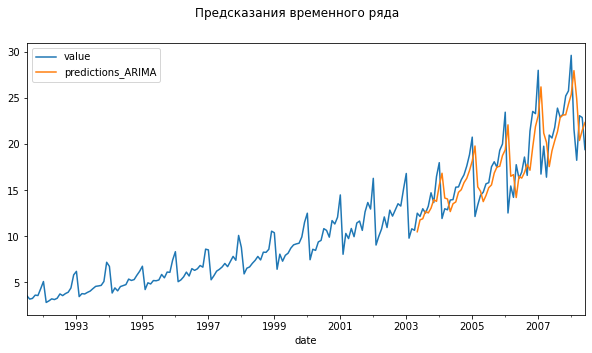

In [23]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data_2.plot(ax=ax, legend=True)
pyplot.show()

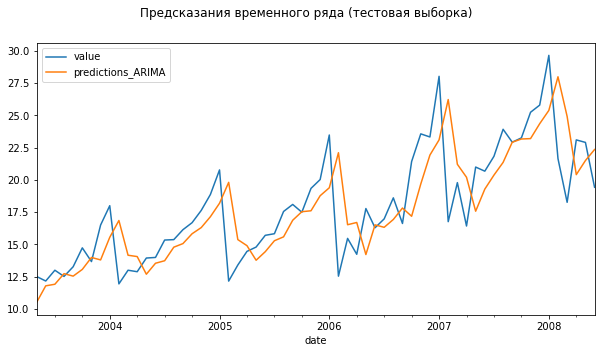

In [24]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

## Прогнозирование временного ряда методом символьной регресии

In [25]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
SR = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [26]:
SR.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

C:\Users\neytr\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      2.60969e+51      137          52.4421              N/A      1.79m
   1   150.29      2.31086e+10       44          44.7186              N/A     39.39s
   2   100.75       3.3938e+08        1          13.2697              N/A     33.95s
   3    49.61      3.36747e+10      141          3.58406              N/A     22.02s
   4    40.66      4.94445e+10      106          2.88037              N/A     23.05s
   5    88.37      3.35228e+09      102          2.08309              N/A     28.27s
   6   107.64      5.72434e+08       41          1.96391              N/A     30.14s
   7    94.38       3.9886e+09       45          1.88267              N/A     30.08s
   8    74.23      2.83158e+10       47          1.85907              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [28]:
print(SR._program)

add(div(X0, 14.579), sub(sub(div(X0, X0), sin(sub(sub(-10.392, 71.983), sin(sin(sin(sin(sin(sin(div(X0, 14.579)))))))))), sin(-83.389)))


In [29]:
# Предсказания
y_sr = SR.predict(np.array(xnum_test).reshape(-1, 1))
y_sr[:10]

array([12.1262825 , 12.14957997, 12.17778464, 12.21103469, 12.24916232,
       12.29180476, 12.33849853, 12.38874853, 12.44207316, 12.49803004])

In [30]:
# Записываем предсказания в DataFrame
data_2['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_sr)

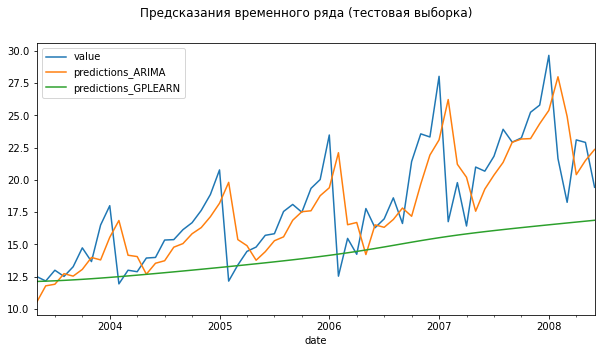

In [31]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

In [32]:
error_SR = mean_squared_error(test, y_sr, squared=False)

In [33]:
# Ошибка прогноза
np.mean(Y), error_SR

(10.694429582156861, 4.902532668025038)

## Качество прогноза моделей

In [34]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [35]:
print("ARIMA")
print_metrics(test, predictions_arima)

print("\nGPLEARN")
print_metrics(test, y_sr)

ARIMA
R^2: 0.47029079438876575
MSE: 3.087041392899832
MAE: 2.255391041263479

GPLEARN
R^2: -0.3359604683725561
MSE: 4.902532668025038
MAE: 3.806162938096472


## Вывод: Лучше оказалась ARIMA.